In [1]:
import numpy as np
from numpy.fft import fft, fftfreq
import matplotlib.pyplot as plt
from astropy.io import fits

## Reading the Files

### Broad Band

In [33]:
result_b = fits.open('acisf05031_001N021_r0097b_lc3.fits')
print(result_b.info())
resolution_b = result_b[1].header['TIMEDEL']
print(f'Time resolution = {resolution_b} s')
date_start = result_b[1].header['DATE-OBS']
date_end = result_b[1].header['DATE-END']
print(f'Observation Timeline : {date_start} to {date_end}\n\n')

Filename: acisf05031_001N021_r0097b_lc3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  LIGHTCURVE    1 BinTableHDU    163   3975R x 5C   [1D, 1D, 1D, 1D, 1D]   
  2  BKGLIGHTCURVE    1 BinTableHDU    169   3975R x 5C   [1D, 1D, 1D, 1D, 1D]   
None
Time resolution = 16.672176063061 s
Observation Timeline : 2004-09-26T14:48:04 to 2004-09-27T09:41:13




## Extracting the Data

### Broad Band

In [34]:
lc_b = result_b[1].data #Lightcurve

#arrays
time_b = lc_b['Time']
count_rate_b = lc_b['COUNT_RATE']
count_rate_err_b = lc_b['COUNT_RATE_ERR']

#starting time from zero
dt_b = time_b - time_b[0]

## Representing the Data

### Broad Band

Text(0, 0.5, 'Countrate in counts/sec')

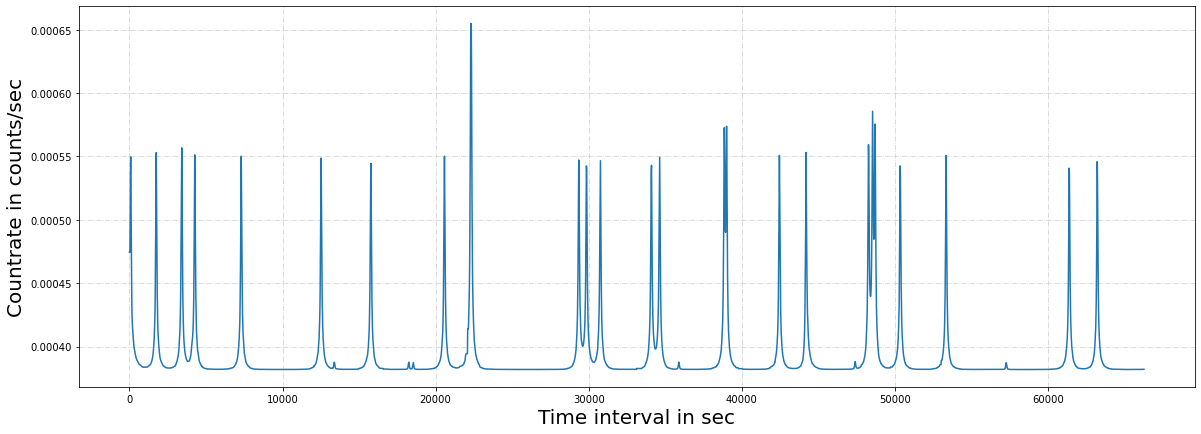

In [35]:
plt.figure(figsize = [20,7], facecolor = 'w')
plt.plot(dt_b, count_rate_b)
plt.grid(color = 'lightgrey', ls = '-.')
plt.xlabel('Time interval in sec', fontsize = 20)
plt.ylabel('Countrate in counts/sec', fontsize = 20)


## Binning the Data


Binned resolution is 883.6253313422329s


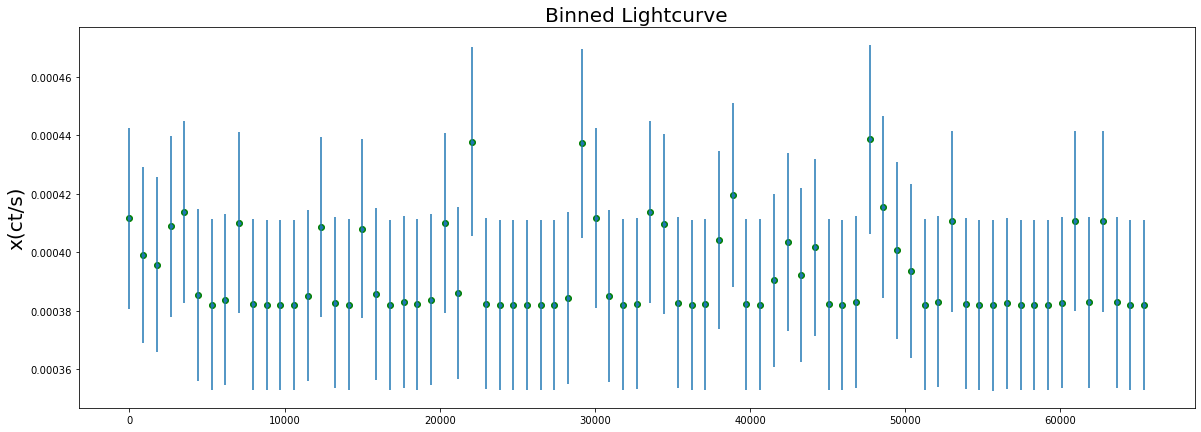

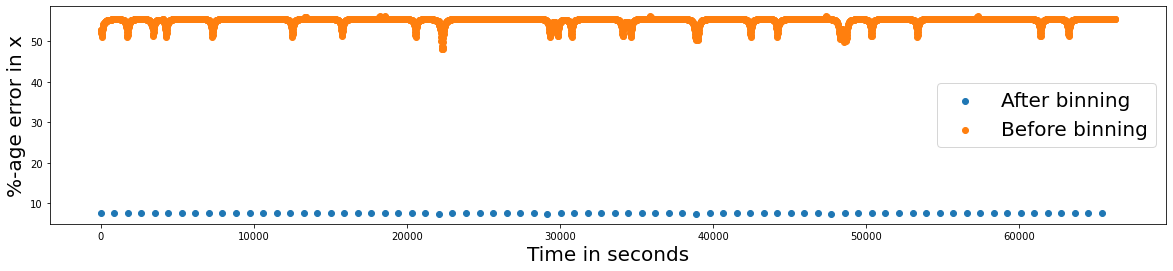

In [39]:
n_total_b = 3975 #Total data points
n_bin_b = 75 #Number of bins
bin_size_b = int(n_total_b/n_bin_b) #Bin size in units of data points
binned_resolution_b = bin_size_b*resolution_b
print(f'Binned resolution is {binned_resolution_b}s')

cr_binned_b= np.zeros(n_bin_b)
t_binned_b= np.zeros(n_bin_b)
err_binned_b = np.zeros(n_bin_b)

for i in range(n_bin_b):
    t_binned_b[i] = dt_b[bin_size_b*i]
for i in range(n_bin_b):
    sum_err_sq = 0
    for j in range((bin_size_b)):
        #summing and averaging all the counts 
        cr_binned_b[i] += count_rate_b[j+i*bin_size_b]/bin_size_b
        #summing square errors
        sum_err_sq += count_rate_err_b[j+i*bin_size_b]**2 
    err_binned_b[i] = (sum_err_sq/bin_size_b**2)**0.5 

#Percentage error before and after binning
err_percent_binned_b = []
err_percent_b = []
for i in range(n_bin_b):
    err_percent_binned_b.append((err_binned_b[i]/cr_binned_b[i])*100)
for i in range(n_total_b):
    err_percent_b.append((count_rate_err_b[i]/count_rate_b[i])*100)
    
plt.figure(figsize = [20,7], facecolor = 'w')
plt.scatter(t_binned_b,cr_binned_b,c='green')
plt.errorbar(t_binned_b, cr_binned_b, err_binned_b,fmt = '.')
plt.title('Binned Lightcurve', fontsize = 20)
plt.ylabel('x(ct/s)', fontsize = 20)
plt.figure(figsize = [20,4], facecolor = 'w')
plt.scatter(t_binned_b,err_percent_binned_b, label = 'After binning')
plt.scatter(dt_b[:n_total_b],err_percent_b, label = 'Before binning')
#plt.ylim(9.3,11)
plt.ylabel('%-age error in x', fontsize = 20)
plt.xlabel('Time in seconds', fontsize = 20)
plt.legend(fontsize = 20)

## Statistics from the binned light curve

Text(0, 0.5, '$σ_{NXS}^2$')

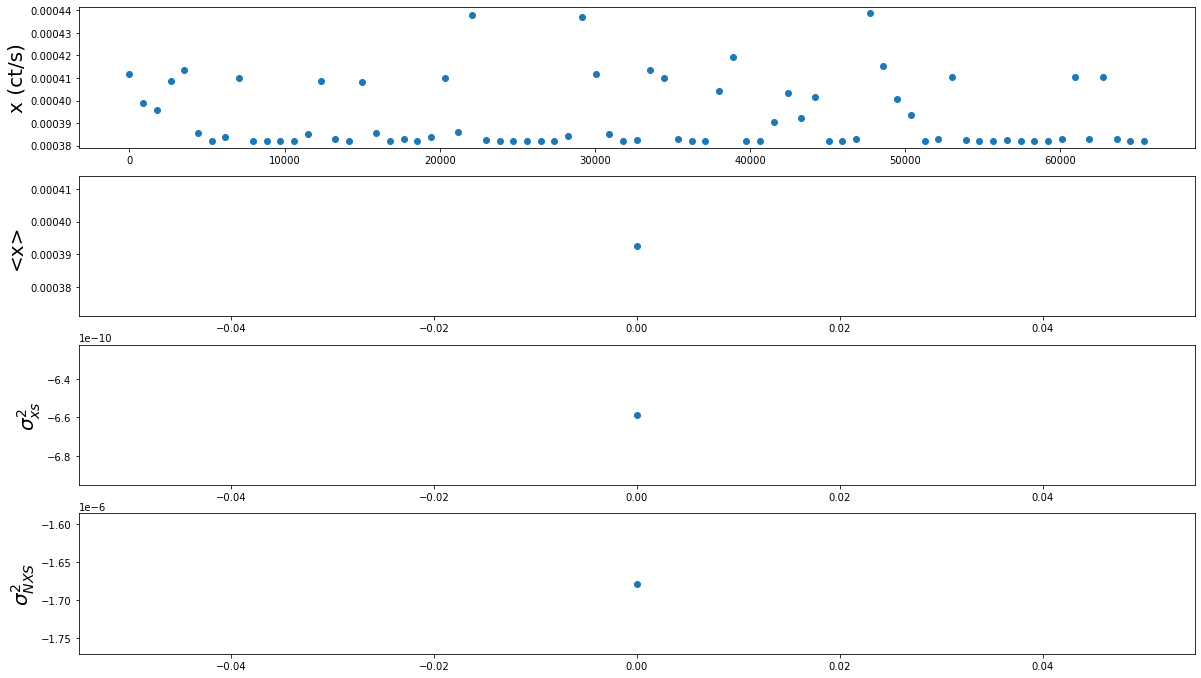

In [40]:
#MAKING AVG FLUX OF EVERY 20 POINTS
n_binned = 75 #Total data points(already binned)
bin_size = 75 #size of the bin in data points
n_points = int(n_binned/bin_size) #no. of data points

#print(n_points)
t_avg = [] #time for avg count of bin_size
c_avg = [] #avg count rate on bin_size points bin
for i in range(n_points):
    t_avg.append(t_binned_b[i*bin_size])
    #print(i,i*25)
    sum = 0
    for j in range(bin_size):
        sum += cr_binned_b[j+i*bin_size]
    c_avg.append(sum/bin_size)
    
var = [] #variance
xs_var = [] #excess variance
for i in range(n_points):
    sum = 0
    sum_err_sq = 0 #sum of squared err
    for j in range(0,bin_size):
        sum += (cr_binned_b[j+i*bin_size] - c_avg[i])**2
        sum_err_sq += (err_binned_b[j+i*bin_size])**2
    avg_err_sq = sum_err_sq/bin_size
    var.append(sum/(bin_size - 1))
    xs_var.append(var[i] - avg_err_sq)

#NORMALIZATION OF XS_VARIANCE
norm_xs_var = []
for i in range(n_points):
    norm_xs_var.append(xs_var[i]/c_avg[i])
    
#EXPECTATION VALUE OF VARIANCE
'''
expect_var = []
t_further = []
for i in range(7):
    sum = 0
    t_further.append(t_avg[i*20])
    for j in range(20):
        sum += var[j+i*20]
    expect_var.append(sum/20)
'''    
#PLOTTING
fig = plt.figure(figsize = [20,15], facecolor = 'w')
ax1 = plt.subplot(511)
ax2 = plt.subplot(512)
ax3 = plt.subplot(513)
ax4 = plt.subplot(514)
ax1.scatter(t_binned_b, cr_binned_b)
ax1.set_ylabel('x (ct/s)', fontsize = 20)
ax2.scatter(t_avg, c_avg)
ax2.set_ylabel('<x>', fontsize = 20)
ax3.scatter(t_avg, xs_var)
ax3.set_ylabel('$σ_{xs}^2$', fontsize = 20)
#ax3.set_yscale('log')
ax4.scatter(t_avg, norm_xs_var)
ax4.set_ylabel('$σ_{NXS}^2$', fontsize = 20)
#ax4.set_yscale('log')
#ax4.scatter(t_further, expect_var)
#ax4.set_ylabel('<$S^2$>', fontsize = 20)
#ax4.set_yscale('log')

## Histogram of count rate


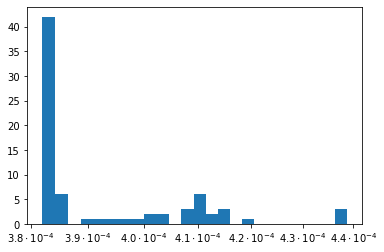

In [44]:
x=plt.hist(cr_binned_b, bins = 25)
plt.xscale('logit')

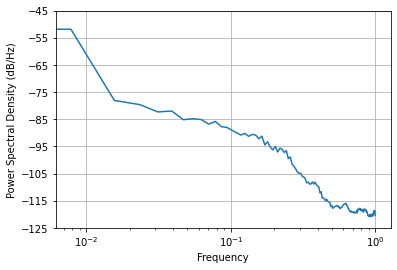

In [49]:
x = plt.psd(count_rate_b)
plt.xscale('log')